In [119]:
import getpass
import os
from pinecone import Pinecone, ServerlessSpec
from dotenv import load_dotenv
load_dotenv()

if not os.getenv("PINECONE_API_KEY"):
    os.environ["PINECONE_API_KEY"] = getpass.getpass("Enter your Pinecone API key: ")

pinecone_api_key = os.environ.get("PINECONE_API_KEY")

pc = Pinecone(api_key=pinecone_api_key)

In [ ]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

In [80]:
from langchain_community.document_loaders import PyPDFLoader, DirectoryLoader

# Adjust the path to where your PDF is located
data_path = "./books"

# Load all PDFs from the directory
loader = DirectoryLoader(
    data_path,
    glob='*.pdf',
    loader_cls=PyPDFLoader
)
    
# This gives you one document per page
documents=loader.load()

In [67]:
print(f"Loaded {len(documents)} pages from PDF(s)")

Loaded 480 pages from PDF(s)


In [81]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Create the text splitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=750,
    chunk_overlap=30,
    length_function=len
)

In [82]:
chunk_documents = text_splitter.split_documents(documents)
len(chunk_documents) 

# So now we have a list of documents with much smaller chunks

1425

In [83]:
import time

index_name = "sapiens" 

existing_indexes = [index_info["name"] for index_info in pc.list_indexes()]

if index_name not in existing_indexes:
    pc.create_index(
        name=index_name,
        dimension=1536,
        metric="cosine",
        spec=ServerlessSpec(cloud="aws", region="us-east-1"),
    )
    while not pc.describe_index(index_name).status["ready"]:
        time.sleep(1)

index = pc.Index(index_name)

In [ ]:
from langchain_pinecone import PineconeVectorStore

vector_store = PineconeVectorStore(index=index, embedding=embeddings)

In [139]:
retriever = vector_store.as_retriever(
    search_type="similarity_score_threshold",
    search_kwargs={"k": 3, "score_threshold": 0.5},
)

In [85]:
import uuid

# Now you can add these to your vector store
doc_ids = [str(uuid.uuid4()) for _ in range(len(chunk_documents))]

In [86]:

# Define a reasonable batch size
batch_size = 50  # Start small and adjust as needed

# Process in batches
for i in range(0, len(chunk_documents), batch_size):
    # Get current batch of documents and IDs
    batch_docs = chunk_documents[i:i+batch_size]
    batch_ids = doc_ids[i:i+batch_size]
    
    # Add the batch to the vector store
    vector_store.add_documents(documents=batch_docs, ids=batch_ids)
    
    print(f"Processed batch {i//batch_size + 1}/{(len(chunk_documents) + batch_size - 1)//batch_size}")

Processed batch 1/29
Processed batch 2/29
Processed batch 3/29
Processed batch 4/29
Processed batch 5/29
Processed batch 6/29
Processed batch 7/29
Processed batch 8/29
Processed batch 9/29
Processed batch 10/29
Processed batch 11/29
Processed batch 12/29
Processed batch 13/29
Processed batch 14/29
Processed batch 15/29
Processed batch 16/29
Processed batch 17/29
Processed batch 18/29
Processed batch 19/29
Processed batch 20/29
Processed batch 21/29
Processed batch 22/29
Processed batch 23/29
Processed batch 24/29
Processed batch 25/29
Processed batch 26/29
Processed batch 27/29
Processed batch 28/29
Processed batch 29/29


In [180]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")

template = """Answer the question based on the following context and the Chathistory. Especially take the latest question into consideration. If the context does not have the answer to the question, simply say you don't know

Chathistory: {history}

Context: {context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

llm = ChatOpenAI(model="gpt-4o")
rag_chain = prompt | llm

In [181]:
from typing import TypedDict, List
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langchain.schema import Document
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, END
from langchain_community.tools.tavily_search import TavilySearchResults 
from langgraph.prebuilt import create_react_agent 
from langgraph.types import Command, interrupt
from typing import Literal


tavily_search = TavilySearchResults(max_results=2)


class AgentState(TypedDict):
    messages: List[BaseMessage]
    documents: List[Document]
    on_topic: str
    rephrased_question: str
    proceed_to_generate: bool
    rephrase_count: int
    question: HumanMessage


class GradeQuestion(BaseModel):
    score: str = Field(
        description="Question is about the specified topics? If yes -> 'Yes' if not -> 'No'"
    )


def question_rewriter(state: AgentState):
    print(f"Entering question_rewriter with following state: {state}")

    # Reset state variables except for 'question' and 'messages'
    state["documents"] = []
    state["on_topic"] = ""
    state["rephrased_question"] = ""
    state["proceed_to_generate"] = False
    state["rephrase_count"] = 0

    if "messages" not in state or state["messages"] is None:
        state["messages"] = []

    if state["question"] not in state["messages"]:
        state["messages"].append(state["question"])

    if len(state["messages"]) > 1:
        conversation = state["messages"][:-1]
        current_question = state["question"].content
        messages = [
            SystemMessage(
                content="You are a helpful assistant that rephrases the user's question to be a standalone question optimized for retrieval."
            )
        ]
        messages.extend(conversation)
        messages.append(HumanMessage(content=current_question))
        rephrase_prompt = ChatPromptTemplate.from_messages(messages)
        llm = ChatOpenAI(model="gpt-4o-mini")
        prompt = rephrase_prompt.format()
        response = llm.invoke(prompt)
        better_question = response.content.strip()
        print(f"question_rewriter: Rephrased question: {better_question}")
        state["rephrased_question"] = better_question
    else:
        state["rephrased_question"] = state["question"].content
    return state

def question_classifier(state: AgentState):
    print("Entering question_classifier")
    system_message = SystemMessage(
        content="""You are a classifier that determines whether a user's question relates to topics covered in Yuval Noah Harari's book "Sapiens" or closely related fields.

    Respond with 'Yes' if the question relates to ANY of these topics:
    1. Human evolution and prehistoric human species
    2. History of Homo sapiens and human civilizations
    3. Agricultural Revolution and its impacts
    4. Formation of societies, religions, and belief systems
    5. Cognitive Revolution and development of language/communication
    6. Development of economies, money, and trade
    7. Empires, nations, and political structures throughout history
    8. Cultural evolution and social constructs
    9. Scientific Revolution and its effects
    10. Anthropology, archaeology, or paleontology related to human development
    11. Psychology of human behavior in historical context
    12. Philosophy of history or human existence
    
    Additionally, respond with 'Yes' for questions that might not be directly addressed in Sapiens but are within related domains of human history, evolution, anthropology, or social sciences.

    Otherwise, respond with 'No' for questions completely unrelated to these topics (like current sports scores, technical support, etc.).
    """
    )

    human_message = HumanMessage(
        content=f"User question: {state['rephrased_question']}"
    )
    grade_prompt = ChatPromptTemplate.from_messages([system_message, human_message])
    llm = ChatOpenAI(model="gpt-4o")
    structured_llm = llm.with_structured_output(GradeQuestion)
    grader_llm = grade_prompt | structured_llm
    result = grader_llm.invoke({})
    state["on_topic"] = result.score.strip()
    print(f"question_classifier: on_topic = {state['on_topic']}")
    return state

def on_topic_router(state: AgentState):
    print("Entering on_topic_router")
    on_topic = state.get("on_topic", "").strip().lower()
    if on_topic == "yes":
        print("Routing to retrieve")
        return "retrieve"
    else:
        print("Routing to off_topic_response")
        return "off_topic_response"


def retrieve(state: AgentState):
    print("Entering retrieve")
    documents = retriever.invoke(state["rephrased_question"])
    print(f"retrieve: Retrieved {len(documents)} documents")
    state["documents"] = documents
    return state


class GradeDocument(BaseModel):
    score: str = Field(
        description="Document is relevant to the question? If yes -> 'Yes' if not -> 'No'"
    )

def retrieval_grader(state: AgentState):
    print("Entering retrieval_grader")
    system_message = SystemMessage(
        content="""You are a grader assessing the relevance of a retrieved document to a user question.
Only answer with 'Yes' or 'No'.

If the document contains information relevant to the user's question, respond with 'Yes'.
Otherwise, respond with 'No'."""
    )

    llm = ChatOpenAI(model="gpt-4o")
    structured_llm = llm.with_structured_output(GradeDocument)

    relevant_docs = []
    for doc in state["documents"]:
        human_message = HumanMessage(
            content=f"User question: {state['rephrased_question']}\n\nRetrieved document:\n{doc.page_content}"
        )
        grade_prompt = ChatPromptTemplate.from_messages([system_message, human_message])
        grader_llm = grade_prompt | structured_llm
        result = grader_llm.invoke({})
        print(
            f"Grading document: {doc.page_content[:30]}... Result: {result.score.strip()}"
        )
        if result.score.strip().lower() == "yes":
            relevant_docs.append(doc)
    state["documents"] = relevant_docs
    state["proceed_to_generate"] = len(relevant_docs) > 0
    print(f"retrieval_grader: proceed_to_generate = {state['proceed_to_generate']}")
    return state

def proceed_router(state: AgentState):
    print("Entering proceed_router")
    rephrase_count = state.get("rephrase_count", 0)
    if state.get("proceed_to_generate", False):
        print("Routing to generate_answer")
        return "generate_answer"
    elif rephrase_count >= 2:
        print("Maximum rephrase attempts reached. Cannot find relevant documents.")
        return "cannot_answer"
    else:
        print("Routing to refine_question")
        return "refine_question"
    
def refine_question(state: AgentState):
    print("Entering refine_question")
    rephrase_count = state.get("rephrase_count", 0)
    if rephrase_count >= 2:
        print("Maximum rephrase attempts reached")
        return state
    question_to_refine = state["rephrased_question"]
    system_message = SystemMessage(
        content="""You are a helpful assistant that slightly refines the user's question to improve retrieval results.
Provide a slightly adjusted version of the question."""
    )
    human_message = HumanMessage(
        content=f"Original question: {question_to_refine}\n\nProvide a slightly refined question."
    )
    refine_prompt = ChatPromptTemplate.from_messages([system_message, human_message])
    llm = ChatOpenAI(model="gpt-4o")
    prompt = refine_prompt.format()
    response = llm.invoke(prompt)
    refined_question = response.content.strip()
    print(f"refine_question: Refined question: {refined_question}")
    state["rephrased_question"] = refined_question
    state["rephrase_count"] = rephrase_count + 1
    return state

def generate_answer(state: AgentState):
    print("Entering generate_answer")
    if "messages" not in state or state["messages"] is None:
        raise ValueError("State must include 'messages' before generating an answer.")

    history = state["messages"]
    documents = state["documents"]
    rephrased_question = state["rephrased_question"]

    response = rag_chain.invoke(
        {"history": history, "context": documents, "question": rephrased_question}
    )

    generation = response.content.strip()

    state["messages"].append(AIMessage(content=generation))
    print(f"generate_answer: Generated response: {generation}")
    return state

def research_node(state: AgentState): 
    print("Entering the research node")
    # Create the research agent
    research_agent = create_react_agent(
        llm,
        tools=[tavily_search],
        state_modifier="""
        You are a research assistant helping to answer questions that couldn't be sufficiently answered using information from the book "Sapiens" by Yuval Noah Harari.

        INSTRUCTIONS:
        1. The user asked a question that our database couldn't answer with information from the Sapiens book.
        2. Use the Tavily search tool to find relevant and accurate information related to the question.
        3. Focus on historical facts, human evolution, anthropology, and related topics.
        4. Provide a complete, educational answer based on your research.
        5. Cite sources where appropriate.

        Your goal is to provide helpful, factual information when our primary knowledge base is insufficient.
    """
    )

    result = research_agent.invoke(state)

    content = result["messages"][-1].content
    state["messages"].append(AIMessage(content=content))

    return state

def cannot_answer(state: AgentState) -> Command[Literal["research_node", END]]:
    print("Entering cannot_answer")
        
    is_approved = interrupt("The system was not able to find the answer. Your approval is needed to make an internet search. Respond with 'yes' or 'no'")

    if is_approved: 
        return Command(goto="research_node")
    else:
        return Command(goto=END)
    

def off_topic_response(state: AgentState):
    print("Entering off_topic_response")
    if "messages" not in state or state["messages"] is None:
        state["messages"] = []
    state["messages"].append(AIMessage(content="I'm sorry! I cannot answer this question!"))
    return state

In [182]:
from langgraph.checkpoint.memory import MemorySaver

checkpointer = MemorySaver()

In [183]:
# Workflow
workflow = StateGraph(AgentState)
workflow.add_node("question_rewriter", question_rewriter)
workflow.add_node("question_classifier", question_classifier)
workflow.add_node("off_topic_response", off_topic_response)
workflow.add_node("retrieve", retrieve)
workflow.add_node("retrieval_grader", retrieval_grader)
workflow.add_node("generate_answer", generate_answer)
workflow.add_node("refine_question", refine_question)
workflow.add_node("cannot_answer", cannot_answer)
workflow.add_node("research_node", research_node)

workflow.add_edge("question_rewriter", "question_classifier")
workflow.add_conditional_edges(
    "question_classifier",
    on_topic_router,
    {
        "retrieve": "retrieve",
        "off_topic_response": "off_topic_response",
    },
)
workflow.add_edge("retrieve", "retrieval_grader")
workflow.add_conditional_edges(
    "retrieval_grader",
    proceed_router,
    {
        "generate_answer": "generate_answer",
        "refine_question": "refine_question",
        "cannot_answer": "cannot_answer",  
    },
)
workflow.add_edge("refine_question", "retrieve")
workflow.add_edge("generate_answer", END)
workflow.add_edge("research_node", END)
workflow.add_edge("off_topic_response", END)
workflow.set_entry_point("question_rewriter")
graph = workflow.compile(checkpointer=checkpointer)

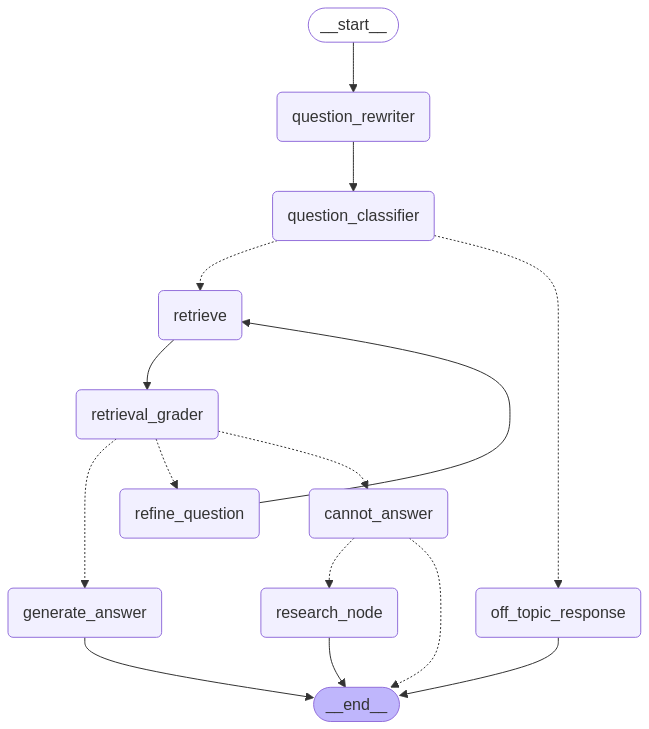

In [184]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [185]:
input_data = {"question": HumanMessage(content="What does the book sapiens deal with?")}
graph.invoke(input=input_data, config={"configurable": {"thread_id": 1}})


Entering question_rewriter with following state: {'question': HumanMessage(content='What does the book sapiens deal with?', additional_kwargs={}, response_metadata={})}
Entering question_classifier
question_classifier: on_topic = Yes
Entering on_topic_router
Routing to retrieve
Entering retrieve


KeyboardInterrupt: 

In [148]:
input_data = {"question": HumanMessage(content="How did the domestication of horses specifically alter warfare tactics during the early Bronze Age across the Eurasian steppe?")}
graph.invoke(input=input_data, config={"configurable": {"thread_id": 2}})

Entering question_rewriter with following state: {'messages': [HumanMessage(content='What were the specific hunting techniques used by early Homo sapiens in the Arctic regions?', additional_kwargs={}, response_metadata={}), AIMessage(content='Early Homo sapiens in the Arctic regions utilized specific hunting techniques that allowed them to adapt and thrive in the harsh, cold climates. According to the context provided from "Sapiens: A Brief History of Humankind," they employed several strategies:\n\n1. **Development of Specialized Tools and Weapons**: Adapted to their needs with tools suited to the Arctic environment, likely including spears and other hunting implements effective against large game.\n\n2. **Snowshoes and Thermal Clothing**: They made snowshoes to move effectively across snow and wore layered furs and skins for insulation against the extreme cold, sewn together tightly with the aid of needles.\n\n3. **Creation of Traps and Slaughtering Grounds**: Archaeological evidence

{'messages': [HumanMessage(content='What were the specific hunting techniques used by early Homo sapiens in the Arctic regions?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Early Homo sapiens in the Arctic regions utilized specific hunting techniques that allowed them to adapt and thrive in the harsh, cold climates. According to the context provided from "Sapiens: A Brief History of Humankind," they employed several strategies:\n\n1. **Development of Specialized Tools and Weapons**: Adapted to their needs with tools suited to the Arctic environment, likely including spears and other hunting implements effective against large game.\n\n2. **Snowshoes and Thermal Clothing**: They made snowshoes to move effectively across snow and wore layered furs and skins for insulation against the extreme cold, sewn together tightly with the aid of needles.\n\n3. **Creation of Traps and Slaughtering Grounds**: Archaeological evidence suggests they set up fences and obstacles to c

In [161]:
input_data = {"question": HumanMessage(content="How did the domestication of horses specifically alter warfare tactics during the early Bronze Age across the Eurasian steppe?")}
graph.invoke(input=input_data, config={"configurable": {"thread_id": 3}})

Entering question_rewriter with following state: {'question': HumanMessage(content='How did the domestication of horses specifically alter warfare tactics during the early Bronze Age across the Eurasian steppe?', additional_kwargs={}, response_metadata={})}
Entering question_classifier
question_classifier: on_topic = Yes
Entering on_topic_router
Routing to retrieve
Entering retrieve
retrieve: Retrieved 3 documents
Entering retrieval_grader
Grading document: (in Arctic areas) freeze them ... Result: No
Grading document: Such domesticated animals – sh... Result: No
Grading document: around 8000 BC; olive trees by... Result: No
retrieval_grader: proceed_to_generate = False
Entering proceed_router
Routing to refine_question
Entering refine_question
refine_question: Refined question: Refined question: How did the domestication of horses impact warfare tactics during the early Bronze Age across the Eurasian steppe?
Entering retrieve
retrieve: Retrieved 3 documents
Entering retrieval_grader
G

{'messages': [HumanMessage(content='How did the domestication of horses specifically alter warfare tactics during the early Bronze Age across the Eurasian steppe?', additional_kwargs={}, response_metadata={})],
 'documents': [],
 'on_topic': 'Yes',
 'rephrased_question': 'What effects did the domestication of horses have on warfare strategies during the early Bronze Age in the Eurasian steppe?',
 'proceed_to_generate': False,
 'rephrase_count': 2,
 'question': HumanMessage(content='How did the domestication of horses specifically alter warfare tactics during the early Bronze Age across the Eurasian steppe?', additional_kwargs={}, response_metadata={})}

In [162]:
graph.invoke(Command(resume="yes"), config={"configurable": {"thread_id": 3}}, stream_mode="updates")

Entering cannot_answer


[{'cannot_answer': None}]

In [170]:
input_data = {"question": HumanMessage(content="How did the domestication of horses specifically alter warfare tactics during the early Bronze Age across the Eurasian steppe?")}
graph.invoke(input=input_data, config={"configurable": {"thread_id": 4}})

Entering question_rewriter with following state: {'question': HumanMessage(content='How did the domestication of horses specifically alter warfare tactics during the early Bronze Age across the Eurasian steppe?', additional_kwargs={}, response_metadata={})}
Entering question_classifier
question_classifier: on_topic = Yes
Entering on_topic_router
Routing to retrieve
Entering retrieve
retrieve: Retrieved 3 documents
Entering retrieval_grader
Grading document: (in Arctic areas) freeze them ... Result: No
Grading document: Such domesticated animals – sh... Result: No
Grading document: around 8000 BC; olive trees by... Result: No
retrieval_grader: proceed_to_generate = False
Entering proceed_router
Routing to refine_question
Entering refine_question
refine_question: Refined question: Refined question: In what ways did the domestication of horses impact warfare tactics in the early Bronze Age on the Eurasian steppe?
Entering retrieve
retrieve: Retrieved 3 documents
Entering retrieval_grader


{'messages': [HumanMessage(content='How did the domestication of horses specifically alter warfare tactics during the early Bronze Age across the Eurasian steppe?', additional_kwargs={}, response_metadata={})],
 'documents': [],
 'on_topic': 'Yes',
 'rephrased_question': 'In what ways did the introduction and domestication of horses influence warfare tactics during the early Bronze Age on the Eurasian steppe?',
 'proceed_to_generate': False,
 'rephrase_count': 2,
 'question': HumanMessage(content='How did the domestication of horses specifically alter warfare tactics during the early Bronze Age across the Eurasian steppe?', additional_kwargs={}, response_metadata={})}

In [171]:
graph.invoke(Command(resume="yes"), config={"configurable": {"thread_id": 4}}, stream_mode="updates")

Entering cannot_answer


[{'cannot_answer': None}]

In [177]:
input_data = {"question": HumanMessage(content="How did the domestication of horses specifically alter warfare tactics during the early Bronze Age across the Eurasian steppe?")}
graph.invoke(input=input_data, config={"configurable": {"thread_id": 5}})

Entering question_rewriter with following state: {'question': HumanMessage(content='How did the domestication of horses specifically alter warfare tactics during the early Bronze Age across the Eurasian steppe?', additional_kwargs={}, response_metadata={})}
Entering question_classifier
question_classifier: on_topic = Yes
Entering on_topic_router
Routing to retrieve
Entering retrieve
retrieve: Retrieved 3 documents
Entering retrieval_grader
Grading document: (in Arctic areas) freeze them ... Result: No
Grading document: Such domesticated animals – sh... Result: No
Grading document: around 8000 BC; olive trees by... Result: No
retrieval_grader: proceed_to_generate = False
Entering proceed_router
Routing to refine_question
Entering refine_question
refine_question: Refined question: Refined question: How did the domestication of horses change warfare tactics during the early Bronze Age on the Eurasian steppe?
Entering retrieve
retrieve: Retrieved 3 documents
Entering retrieval_grader
Gradi

{'messages': [HumanMessage(content='How did the domestication of horses specifically alter warfare tactics during the early Bronze Age across the Eurasian steppe?', additional_kwargs={}, response_metadata={})],
 'documents': [],
 'on_topic': 'Yes',
 'rephrased_question': 'How did the domestication of horses influence warfare tactics during the early Bronze Age on the Eurasian steppe?',
 'proceed_to_generate': False,
 'rephrase_count': 2,
 'question': HumanMessage(content='How did the domestication of horses specifically alter warfare tactics during the early Bronze Age across the Eurasian steppe?', additional_kwargs={}, response_metadata={})}

In [179]:
graph.invoke(Command(resume="yes"), config={"configurable": {"thread_id": 5}}, stream_mode="updates")

Entering cannot_answer


[{'cannot_answer': None}]

In [186]:
input_data = {"question": HumanMessage(content="How did the domestication of horses specifically alter warfare tactics during the early Bronze Age across the Eurasian steppe?")}
graph.invoke(input=input_data, config={"configurable": {"thread_id": 6}})

Entering question_rewriter with following state: {'question': HumanMessage(content='How did the domestication of horses specifically alter warfare tactics during the early Bronze Age across the Eurasian steppe?', additional_kwargs={}, response_metadata={})}
Entering question_classifier
question_classifier: on_topic = Yes
Entering on_topic_router
Routing to retrieve
Entering retrieve
retrieve: Retrieved 3 documents
Entering retrieval_grader
Grading document: (in Arctic areas) freeze them ... Result: No
Grading document: Such domesticated animals – sh... Result: No
Grading document: around 8000 BC; olive trees by... Result: No
retrieval_grader: proceed_to_generate = False
Entering proceed_router
Routing to refine_question
Entering refine_question
refine_question: Refined question: Refined question: How did the domestication of horses influence warfare tactics during the early Bronze Age throughout the Eurasian steppe?
Entering retrieve
retrieve: Retrieved 3 documents
Entering retrieval_g

{'messages': [HumanMessage(content='How did the domestication of horses specifically alter warfare tactics during the early Bronze Age across the Eurasian steppe?', additional_kwargs={}, response_metadata={})],
 'documents': [],
 'on_topic': 'Yes',
 'rephrased_question': 'How did horse domestication impact warfare tactics in the Eurasian steppe during the early Bronze Age?',
 'proceed_to_generate': False,
 'rephrase_count': 2,
 'question': HumanMessage(content='How did the domestication of horses specifically alter warfare tactics during the early Bronze Age across the Eurasian steppe?', additional_kwargs={}, response_metadata={})}

In [187]:
graph.invoke(Command(resume=True), config={"configurable": {"thread_id": 6}}, stream_mode="updates")

Entering cannot_answer
Entering the research node


[{'cannot_answer': None},
 {'research_node': {'messages': [HumanMessage(content='How did the domestication of horses specifically alter warfare tactics during the early Bronze Age across the Eurasian steppe?', additional_kwargs={}, response_metadata={}, id='6f0c4589-ed87-4224-b364-f0b97f034fd3'),
    AIMessage(content="The domestication of horses had a profound impact on warfare tactics during the early Bronze Age across the Eurasian steppe. Here's how it specifically altered these tactics:\n\n1. **Increased Mobility and Speed**: The domestication of horses allowed for rapid movement across the vast stretches of the Eurasian steppe. This mobility enabled mounted warriors to traverse large distances quickly, facilitating attacks and retreats over much greater ranges than previously possible with pedestrian or purely ground-based methods.\n\n2. **Development of Mounted Combat**: While the full development of horseback riding took centuries, early domesticated horses were initially used f